In [4]:
"""Will mainly follow Brain's Cell paper
GP is trained and validated on wt1-wt2 pairs first
Then wt1-mutant pairs are considered as the "unknown" and need ranking system
For Kd > 10000 nM, the pair is no longer considered as binding
"""
import torch
import esm
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from umap import UMAP
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
def add_scaled_columns(dataframe, col1, col2, boundary=10000):
    # Extract the two columns
    sub_df = dataframe[[col1, col2]].copy()

    # Create a combined series for calculating scaling factor
    combined = sub_df[col1].append(sub_df[col2])

    # 1. Handle NaNs
    combined_filled = combined.fillna(1e9)

    # 2. Determine Scaling Factor
    # Find the maximum value excluding the NaN placeholders
    max_val = combined_filled[combined_filled != 1e9].max()

    # Compute the scaling factor so the max_val is just below 10000
    scaling_factor = (boundary - 1) / max_val

    # 3. Normalize Data
    # Scale the two columns and add them to the original dataframe
    dataframe[f"scaled_{col1}"] = sub_df[col1].mul(scaling_factor).fillna(boundary)
    dataframe[f"scaled_{col2}"] = sub_df[col2].mul(scaling_factor).fillna(boundary)
    return dataframe

# Sample dataset
df = pd.DataFrame({
    'column_0': [1, 2, 3, 4, 5, 6, 7, 8],
    'column_1': [0.5, 0.6, 150, 20000, 100000, np.nan, 0.2, 250],
    'column_2': [250, 0.2, 100000, np.nan, 0.6, 0.5, 150, 20000],
    'column_3': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
})

df = add_scaled_columns(df, 'column_1', 'column_2')

print(df)


   column_0  column_1  column_2 column_3  scaled_column_1  scaled_column_2
0         1       0.5     250.0        A         0.049995        24.997500
1         2       0.6       0.2        B         0.059994         0.019998
2         3     150.0  100000.0        C        14.998500      9999.000000
3         4   20000.0       NaN        D      1999.800000     10000.000000
4         5  100000.0       0.6        E      9999.000000         0.059994
5         6       NaN       0.5        F     10000.000000         0.049995
6         7       0.2     150.0        G         0.019998        14.998500
7         8     250.0   20000.0        H        24.997500      1999.800000


/var/tmp/pbs.820860.hn-10-03/ipykernel_210312/939194840.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = sub_df[col1].append(sub_df[col2])


In [6]:
df = pd.read_hdf('reduced_proteins_embeddings_meta.hdf', key='df')
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['wild_seq_2_embeddings']], axis=1)
df['wt1_wt2_concat'] = df.apply(concatenate_vectors, axis=1)
# concatenate wt1+wt2 and wt1+mut
def concatenate_vectors_mut(row):
    return np.concatenate([row['wild_seq_1_embeddings'], row['mutant_seq_embeddings']], axis=1)
df['wt1_mut_concat'] = df.apply(concatenate_vectors_mut, axis=1)
df

#Pdb Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I           LI45G         5.260000e-11        1.120000e-12   
1     1CSE_E_I           LI45S         8.330000e-12        1.120000e-12   
2     1CSE_E_I           LI45P         1.020000e-07        1.120000e-12   
3     1CSE_E_I           LI45I         1.720000e-10        1.120000e-12   
4     1CSE_E_I           LI45D         1.920000e-09        1.120000e-12   
...        ...             ...                  ...                 ...   
2021  2WPT_A_B           FB86A         7.410000e-05        8.200000e-07   
2022  2WPT_A_B     DA33A,FB86A         6.210000e-07        8.200000e-07   
2023  2WPT_A_B           NA34A         6.490000e-07        8.200000e-07   
2024  2WPT_A_B           SB84A         7.090000e-07        8.200000e-07   
2025  2WPT_A_B     SB84A,NA34A         3.920000e-07        8.200000e-07   

                        Protein_1                    Protein_2  \
0            Subtilisin Carlsberg                      Eglin c   
1            Subtilisin Carlsberg                      Eglin c   
2            Subtilisin Carlsberg                      Eglin c   
3            Subtilisin Carlsberg                      Eglin c   
4            Subtilisin Carlsberg                      Eglin c   
...                           ...                          ...   
2021  Colicin E2 immunity protein             Colicin E9 DNase   
2022  Colicin E2 immunity protein             Colicin E9 DNase   
2023             Colicin E9 DNase  Colicin E2 immunity protein   
2024  Colicin E2 immunity protein             Colicin E9 DNase   
2025             Colicin E9 DNase  Colicin E2 immunity protein   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2021  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2022  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2023  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2024  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2025  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...          -4.503866   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.277973   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...           0.233872   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.145449   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDA

# handle Kd results, first, all Kd is multiplied by 10**9 to be nM, several other modifications:
# 1. any reads > 10000. are converted into 10000.
# 2. if after conversion, mut and wt affinity both have 10000., remove that row (both cases no binding)
# 3. if mut is NaN, wt is 10000., remove that row (both cases no binding)
# 4. if mut is NaN, wt is not 10000., change NaN to 10000. (NaN indicating no binding)
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
for col in ['Affinity_mut_parsed', 'Affinity_wt_parsed']:
    df.loc[df[col] > 10000, col] = 10000.
# Drop rows where both columns contain 10000
df = df.drop(df[(df['Affinity_mut_parsed'] == 10000.) & (df['Affinity_wt_parsed'] == 10000.)].index)
# Drop rows where one column is NaN and the other is 10000
df = df.drop(df[((df['Affinity_mut_parsed'].isna()) & (df['Affinity_wt_parsed'] == 10000.)) | ((df['Affinity_wt_parsed'].isna()) & (df['Affinity_mut_parsed'] == 10000.))].index)

# Modify NaN in 'col1' when 'col2' is not 10000, and vice-versa
for col, other_col in [('Affinity_mut_parsed', 'Affinity_wt_parsed'), ('Affinity_wt_parsed', 'Affinity_mut_parsed')]:
    mask = (df[col].isna()) & (df[other_col] != 10000.)
    df.loc[mask, col] = 10000.
df

In [7]:
# alternative method of normalization
df['Affinity_mut_parsed'] = df['Affinity_mut_parsed'] * (10 ** 9)
df['Affinity_wt_parsed'] = df['Affinity_wt_parsed'] * (10 ** 9)
df = add_scaled_columns(df, 'Affinity_mut_parsed', 'Affinity_wt_parsed')
df

/var/tmp/pbs.820860.hn-10-03/ipykernel_210312/939194840.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = sub_df[col1].append(sub_df[col2])


#Pdb Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I           LI45G              0.05260             0.00112   
1     1CSE_E_I           LI45S              0.00833             0.00112   
2     1CSE_E_I           LI45P            102.00000             0.00112   
3     1CSE_E_I           LI45I              0.17200             0.00112   
4     1CSE_E_I           LI45D              1.92000             0.00112   
...        ...             ...                  ...                 ...   
2021  2WPT_A_B           FB86A          74100.00000           820.00000   
2022  2WPT_A_B     DA33A,FB86A            621.00000           820.00000   
2023  2WPT_A_B           NA34A            649.00000           820.00000   
2024  2WPT_A_B           SB84A            709.00000           820.00000   
2025  2WPT_A_B     SB84A,NA34A            392.00000           820.00000   

                        Protein_1                    Protein_2  \
0            Subtilisin Carlsberg                      Eglin c   
1            Subtilisin Carlsberg                      Eglin c   
2            Subtilisin Carlsberg                      Eglin c   
3            Subtilisin Carlsberg                      Eglin c   
4            Subtilisin Carlsberg                      Eglin c   
...                           ...                          ...   
2021  Colicin E2 immunity protein             Colicin E9 DNase   
2022  Colicin E2 immunity protein             Colicin E9 DNase   
2023             Colicin E9 DNase  Colicin E2 immunity protein   
2024  Colicin E2 immunity protein             Colicin E9 DNase   
2025             Colicin E9 DNase  Colicin E2 immunity protein   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2021  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2022  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2023  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2024  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2025  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDNKLVREFERLTEH...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2021  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...          -4.503866   
2022  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.277973   
2023  MELKHSISDYTEAEFLEFVKKIARAEGATECDDAKLVREFERLTEH...           0.233872   
2024  MESKRNKPGKATGKGKPVGDKWLDDAGKDSGAPIPDRIADKLRDKE...           0.145449   
2025  MELKHSISDYTEAEFLEFVKKIARAEGATECDDA

In [8]:
max_molar = df[['scaled_Affinity_mut_parsed', 'scaled_Affinity_wt_parsed']].max().max()
max_molar

10000.0

In [9]:
# construct wt training set, remove the duplicated wt1-wt2 entries
dt = df.copy()
dt.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
dt

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G               0.0526             0.00112   
6     1ACB_E_I              LI45G              45.5000             0.00149   
12    1SBN_E_I              RI45K               0.0320             0.05400   
13    1SIB_E_I              KI53R               0.0320             0.11000   
14    1Y1K_E_I              AI58T               0.0030             0.30000   
...        ...                ...                  ...                 ...   
2008  5UFE_A_B              QB27R              82.4000            50.30000   
2012  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
2014  5TAR_A_B      TA183A,KA184E          231000.0000          2300.00000   
2015  1KBH_A_B               QA3W              42.9000            34.00000   
2019  2KSO_A_B              RA56E            1700.0000          5200.00000   

                      Protein_1                     Protein_2  \
0          Subtilisin Carlsberg                       Eglin c   
6     Bovine alpha-chymotrypsin                       Eglin c   
12               Subtilisin BPN                       Eglin c   
13               Subtilisin BPN                       Eglin c   
14               Subtilisin BPN      Chymotrypsin inhibitor 2   
...                         ...                           ...   
2008                      K-Ras                       R11.1.6   
2012                      K-Ras                       R11.1.6   
2014                  PDE delta                         K-Ras   
2015                  CREB NCBD                          ACTR   
2019                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
6     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
12    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
13    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
14    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
2008  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
...                                                 ...                ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2019  HHHHHHSSGL

In [10]:
train_wt, test_wt = train_test_split(dt[['wt1_wt2_concat', 'scaled_Affinity_wt_parsed']], test_size=0.2, random_state=42)
x_train_wt_array = np.vstack(train_wt['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(train_wt['scaled_Affinity_wt_parsed'].to_numpy())
x_test_wt_array = np.vstack(test_wt['wt1_wt2_concat'].to_numpy())
y_test_wt_array = np.vstack(test_wt['scaled_Affinity_wt_parsed'].to_numpy())

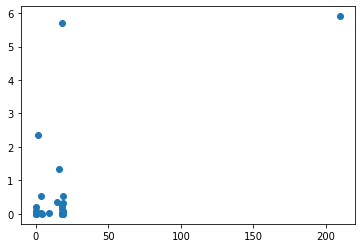

In [11]:
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
n_samples, n_features = x_train_wt_array.shape
model = gpr.fit(x_train_wt_array, y_train_wt_array)
y_pred_wt, y_var_wt = gpr.predict(x_test_wt_array, return_std=True)
plt.figure()
plt.scatter(y_pred_wt, y_test_wt_array)
plt.show()

In [12]:
import scipy.stats as ss
ss.spearmanr(y_pred_wt, y_test_wt_array)

SpearmanrResult(correlation=0.1487433771098107, pvalue=0.46833337540323816)

In [13]:
ss.pearsonr(y_pred_wt, y_test_wt_array)

(array([0.6672280605538177], dtype=object), 0.00019671522340809487)

In [14]:
from scipy.stats import rankdata
def acquisition_rank(y_pred, var_pred, beta=1.):
    print(y_pred.shape, var_pred.shape)
    return rankdata(y_pred) + (beta * rankdata(var_pred))

In [15]:
# assign ranking and uncertainties
acquisition = acquisition_rank(y_pred_wt, y_var_wt)
acquisition

(26,) (26,)


array([22., 12., 30., 36., 43., 47.,  3., 50., 36., 37., 30.,  9., 35.,
       14., 35., 47., 30.,  9.,  6., 43.,  3., 16., 26., 40., 19., 24.])

In [16]:
# after examined that GP performance is ok for wts, use all wts are the training set for the process
# construct wt training set, remove the duplicated wt1-wt2 entries
dt_train = df.copy()
dt_train.drop_duplicates(subset=['wild_seq_1', 'wild_seq_2'], inplace=True)
x_train_wt_array = np.vstack(dt_train['wt1_wt2_concat'].to_numpy())
y_train_wt_array = np.vstack(dt_train['scaled_Affinity_wt_parsed'].to_numpy())
kernel_function = C(10000., 'fixed') * RBF(1., 'fixed')
gpr = GaussianProcessRegressor(kernel=kernel_function, random_state=0, normalize_y=True, copy_X_train=False)
model = gpr.fit(x_train_wt_array, y_train_wt_array)
dt_train

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G               0.0526             0.00112   
6     1ACB_E_I              LI45G              45.5000             0.00149   
12    1SBN_E_I              RI45K               0.0320             0.05400   
13    1SIB_E_I              KI53R               0.0320             0.11000   
14    1Y1K_E_I              AI58T               0.0030             0.30000   
...        ...                ...                  ...                 ...   
2008  5UFE_A_B              QB27R              82.4000            50.30000   
2012  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
2014  5TAR_A_B      TA183A,KA184E          231000.0000          2300.00000   
2015  1KBH_A_B               QA3W              42.9000            34.00000   
2019  2KSO_A_B              RA56E            1700.0000          5200.00000   

                      Protein_1                     Protein_2  \
0          Subtilisin Carlsberg                       Eglin c   
6     Bovine alpha-chymotrypsin                       Eglin c   
12               Subtilisin BPN                       Eglin c   
13               Subtilisin BPN                       Eglin c   
14               Subtilisin BPN      Chymotrypsin inhibitor 2   
...                         ...                           ...   
2008                      K-Ras                       R11.1.6   
2012                      K-Ras                       R11.1.6   
2014                  PDE delta                         K-Ras   
2015                  CREB NCBD                          ACTR   
2019                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
6     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
12    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
13    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
14    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
2008  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
6     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
12    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
13    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
14    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
...                                                 ...                ...   
2008  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2019  HHHHHHSSGL

In [17]:
# construct predicting set, remove the duplicated wt1-mut entries
dt_mut = df.copy()
dt_mut.drop_duplicates(subset=['wild_seq_1', 'mutant_seq'], inplace=True)
unknown_array = np.vstack(dt_mut['wt1_mut_concat'].to_numpy())
unknown_array_y = np.vstack(dt_mut['scaled_Affinity_mut_parsed'].to_numpy())
y_pred_mut, y_var_mut = gpr.predict(unknown_array, return_std=True)
dt_mut

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G              0.05260             0.00112   
1     1CSE_E_I              LI45S              0.00833             0.00112   
2     1CSE_E_I              LI45P            102.00000             0.00112   
3     1CSE_E_I              LI45I              0.17200             0.00112   
4     1CSE_E_I              LI45D              1.92000             0.00112   
...        ...                ...                  ...                 ...   
2012  5UFQ_A_C  DA12G,QC27R,KC59G             82.40000             6.40000   
2014  5TAR_A_B      TA183A,KA184E         231000.00000          2300.00000   
2015  1KBH_A_B               QA3W             42.90000            34.00000   
2016  1KBH_A_B              LA37W            143.00000            34.00000   
2019  2KSO_A_B              RA56E           1700.00000          5200.00000   

                 Protein_1                     Protein_2  \
0     Subtilisin Carlsberg                       Eglin c   
1     Subtilisin Carlsberg                       Eglin c   
2     Subtilisin Carlsberg                       Eglin c   
3     Subtilisin Carlsberg                       Eglin c   
4     Subtilisin Carlsberg                       Eglin c   
...                    ...                           ...   
2012                 K-Ras                       R11.1.6   
2014             PDE delta                         K-Ras   
2015             CREB NCBD                          ACTR   
2016             CREB NCBD                          ACTR   
2019             SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
2012  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2014  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
2015  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2016  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
2019  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
2015    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2016    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
2012  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
2014  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
2015    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
2016    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK          -1.436484   
2019  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030  

In [18]:
acquisition_unk = acquisition_rank(y_pred_mut, y_var_mut)

(1536,) (1536,)


In [19]:
def acquisition_scatter(y_unk_pred, var_unk_pred, acquisition):
    y_unk_pred = y_unk_pred[:]
    y_unk_pred[y_unk_pred > 10000] = 10000

    plt.figure()
    plt.scatter(y_unk_pred, var_unk_pred, alpha=0.5, c=-acquisition,
                cmap='hot')
    plt.xlabel('Predicted score')
    plt.ylabel('Variance')
    plt.show()

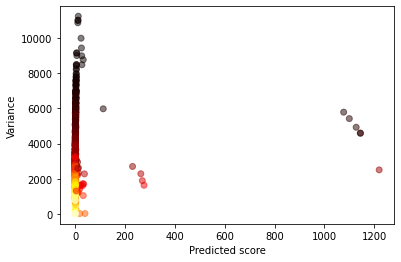

In [17]:
acquisition_scatter(y_pred_mut, y_var_mut, acquisition_unk)

In [18]:
# draw other types of visualization

In [20]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(x_train_wt_array)
dist = np.ravel(nbrs.kneighbors(unknown_array)[0])

In [21]:
whos_my_nbr = np.ravel(nbrs.kneighbors(unknown_array)[1])

In [22]:
ss.spearmanr(y_var_mut, dist)

SpearmanrResult(correlation=0.998298031969012, pvalue=0.0)

In [23]:
ss.pearsonr(y_var_mut, dist)

(0.9767692575279923, 0.0)

In [24]:
# stack the known and unknown arrays together
X = np.vstack([x_train_wt_array, unknown_array])

In [25]:
from umap import UMAP
um = UMAP(
        n_neighbors=15,
        min_dist=0.5,
        n_components=2,
        metric='euclidean',
    )
X_umap = um.fit_transform(X)

In [26]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(
        n_components=2,
        n_jobs=20,
    )
X_tsne = tsne.fit_transform(X)

In [27]:
# training data points are labeled as 0 and unknown data points are labeled as 1
labels = np.concatenate([
        np.zeros(len(x_train_wt_array)), np.ones(len(unknown_array))
    ])

In [28]:
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

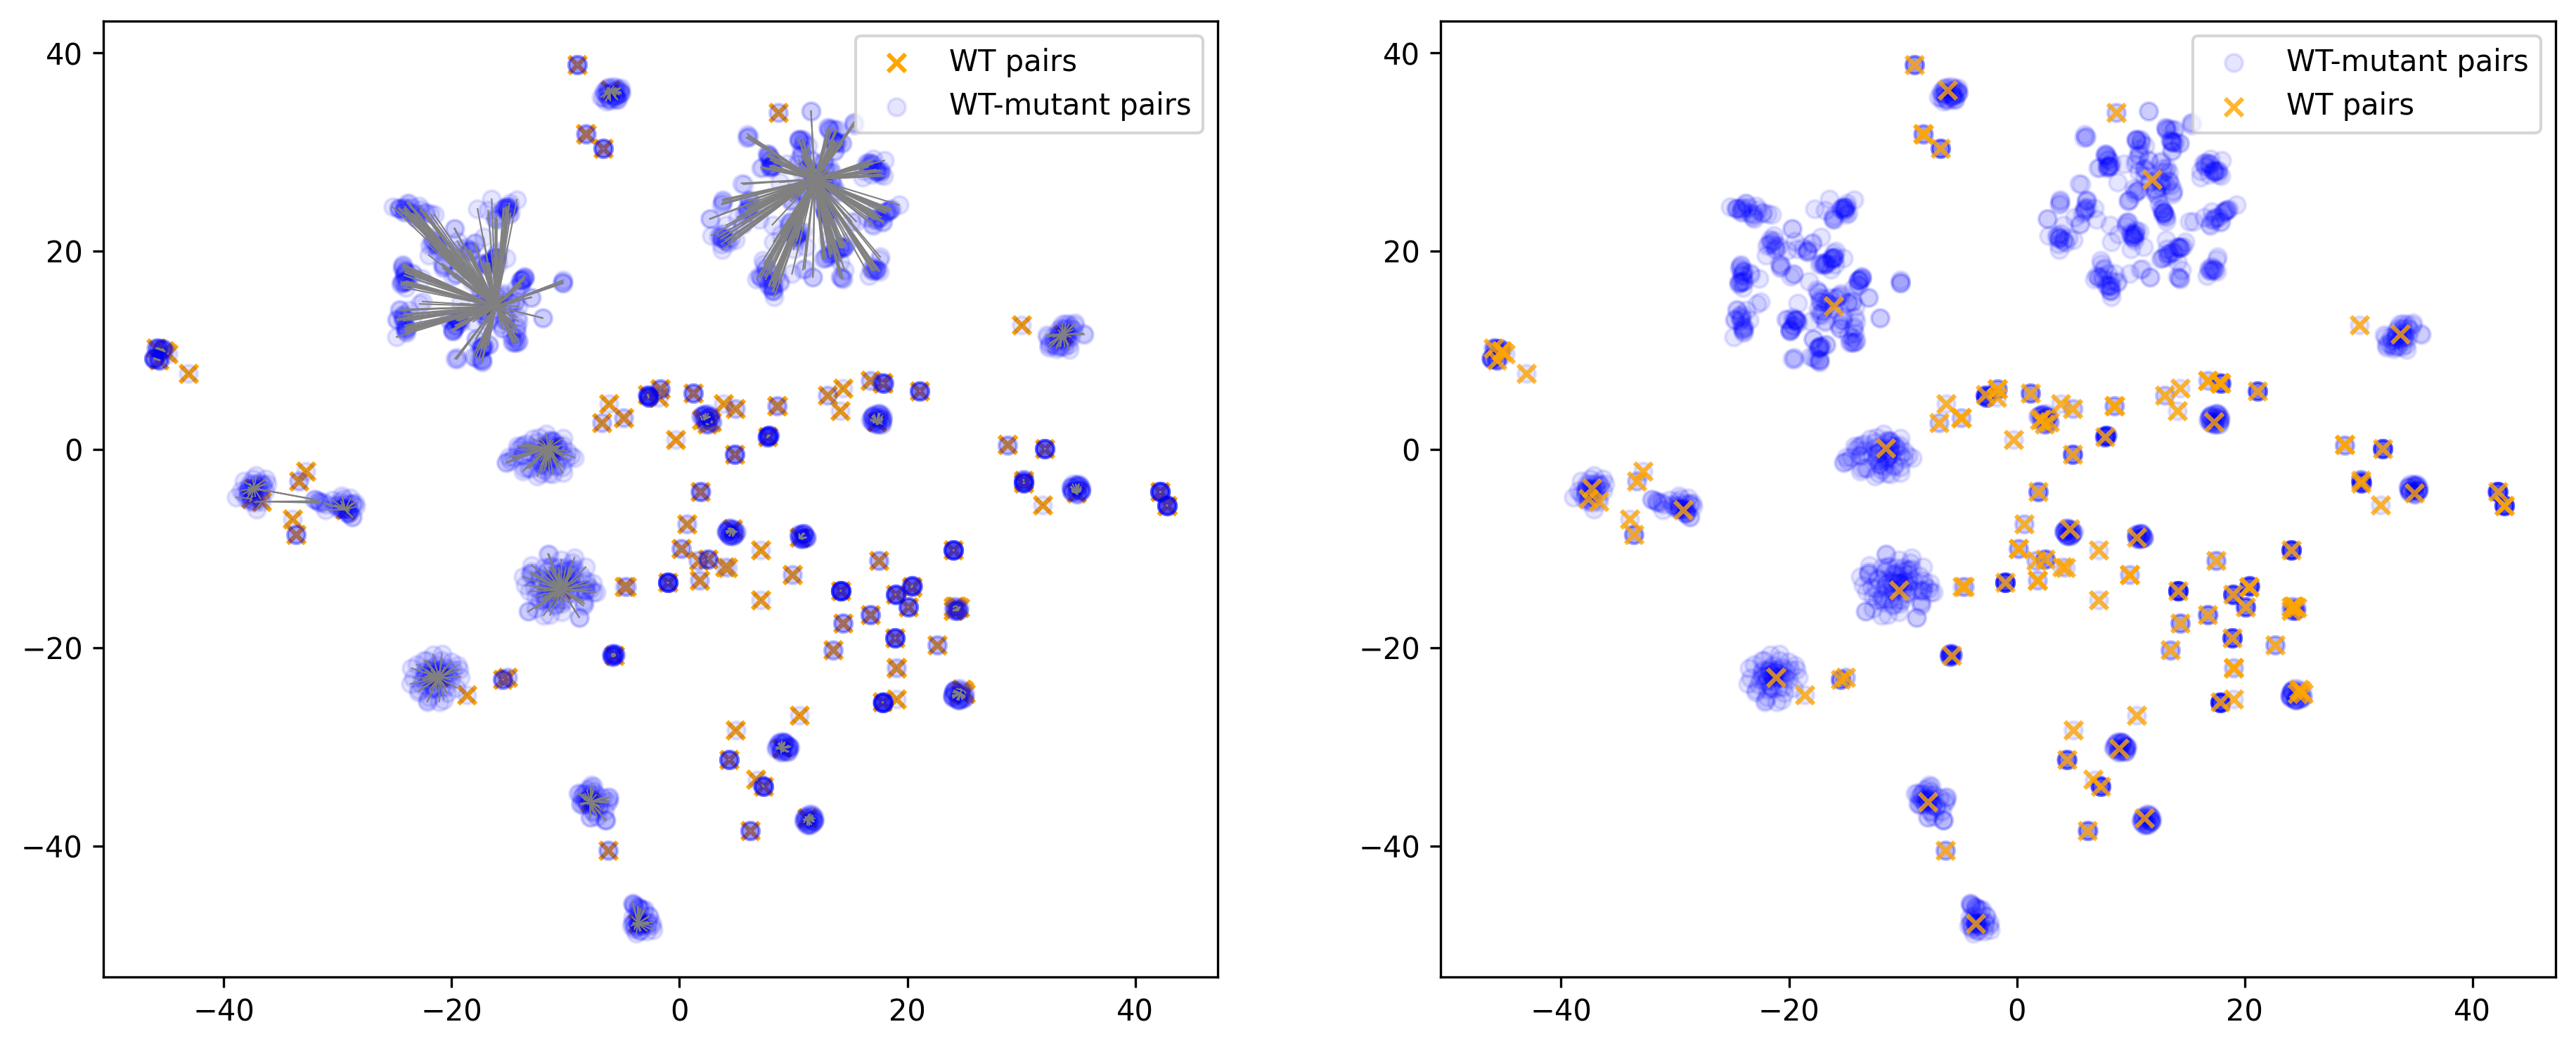

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), dpi=300)
ax1.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='orange', marker='x', label='WT pairs')
ax1.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue',  alpha=0.1, label='WT-mutant pairs')
for i, index in enumerate(whos_my_nbr):
    ax1.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)
ax1.legend()
ax2.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue', alpha=0.1, label='WT-mutant pairs')
ax2.scatter(tsne_obs[:, 0], tsne_obs[:, 1],
            color='orange', alpha=0.8, marker='x', label='WT pairs')
ax2.legend()
fig.savefig('./outputs/figures/tsne_skempi_wt_mut.png')

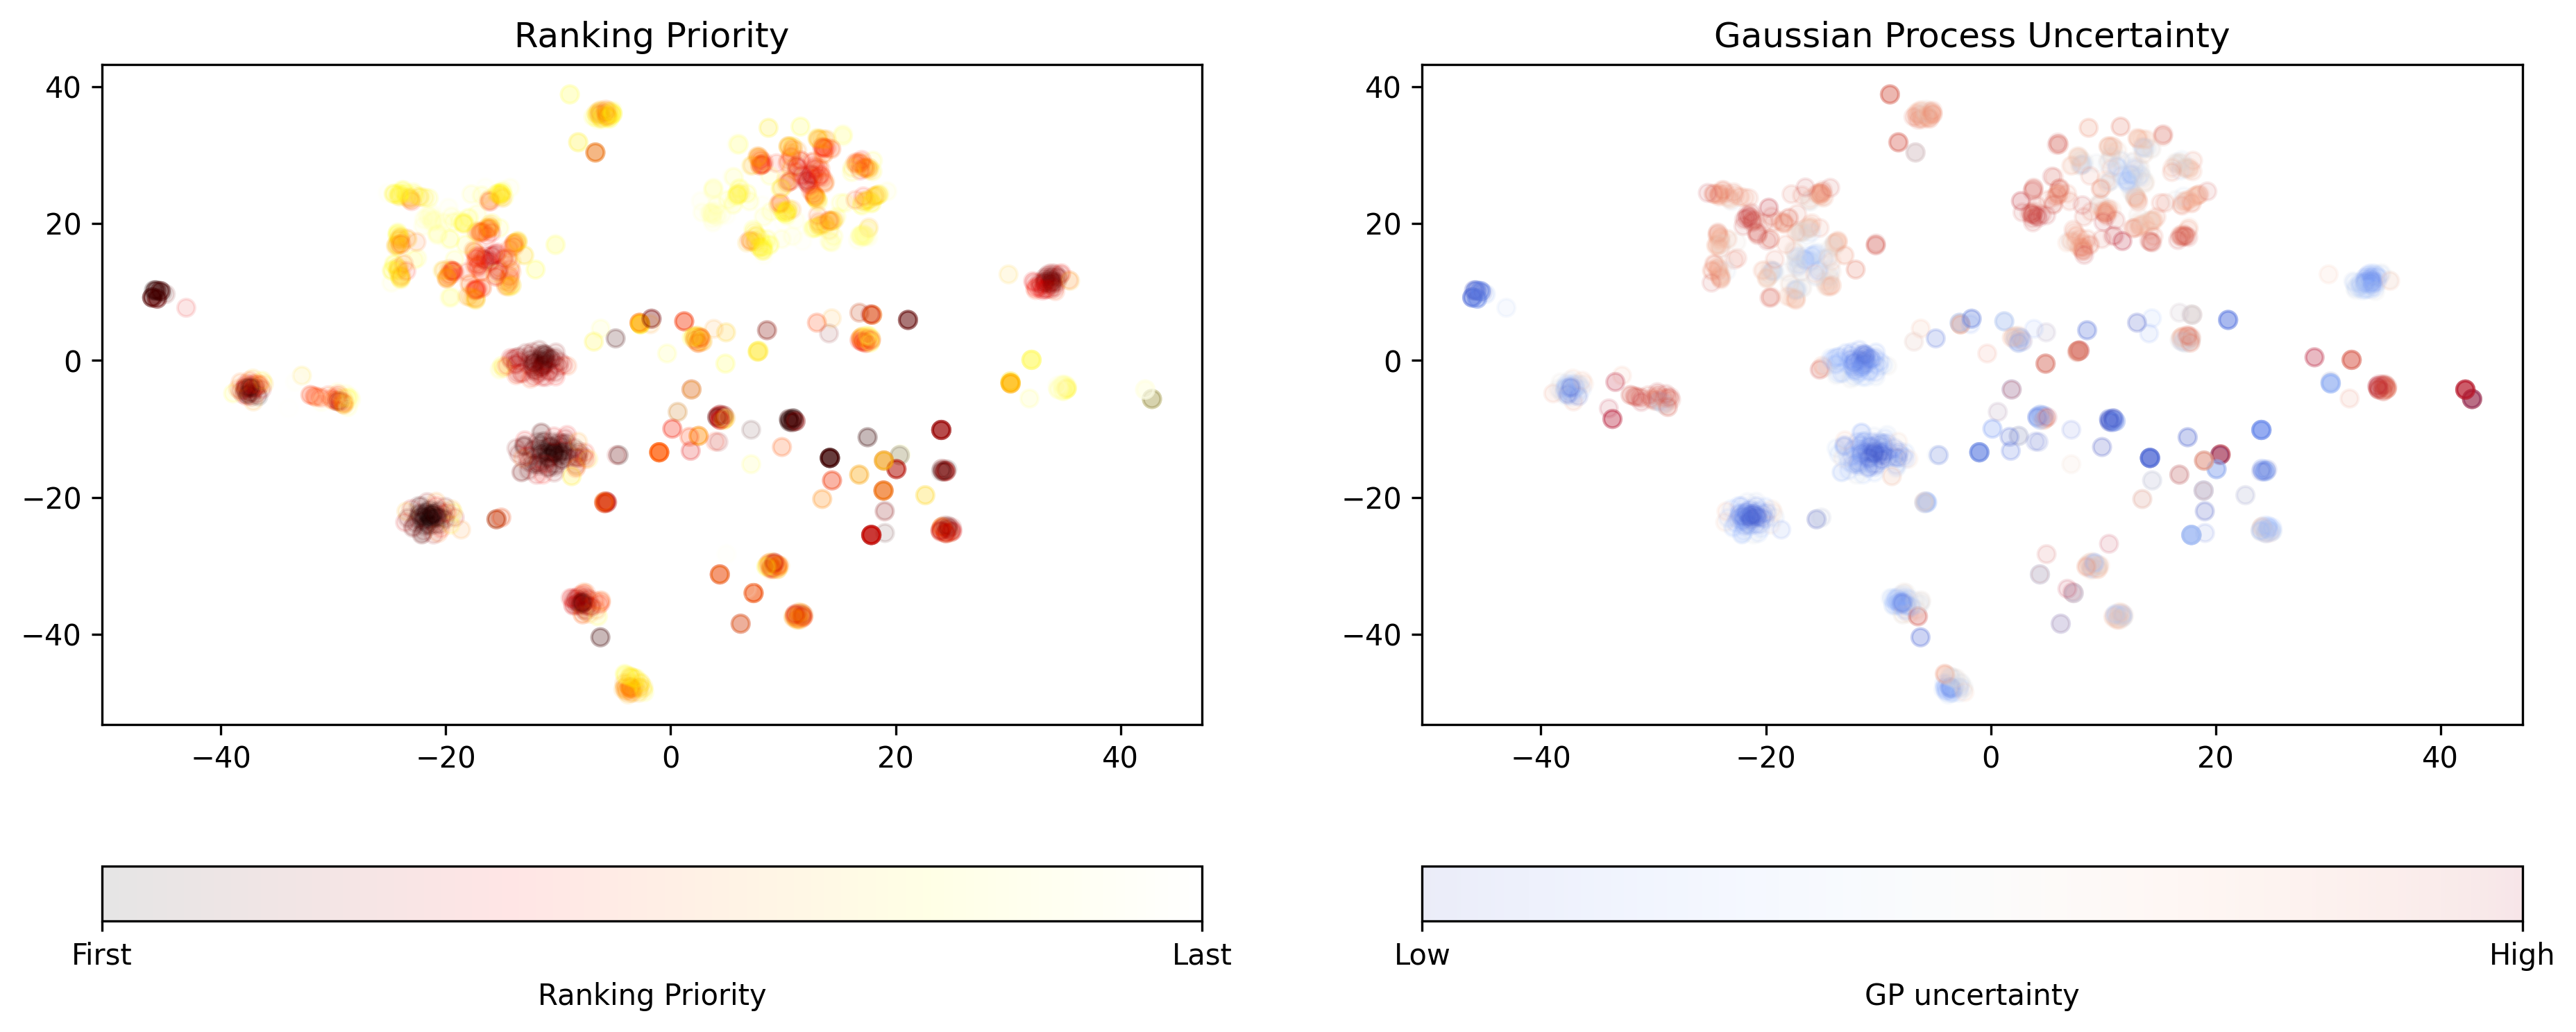

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), dpi=300)
scatter1 = ax1.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1],
            c=acquisition_unk, alpha=0.1, cmap='hot')
ax1.set_title('Ranking Priority')
# visualize the mutant based on the rank data of the GP variances (uncertainty)
scatter2 = ax2.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1],
            c=ss.rankdata(y_var_mut), alpha=0.1, cmap='coolwarm')
ax2.set_title('Gaussian Process Uncertainty')
cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='horizontal')
cbar1.set_ticks([acquisition_unk.min(), acquisition_unk.max()])
cbar1.set_ticklabels(['First',  'Last'])
cbar1.set_label('Ranking Priority')
cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='horizontal')
cbar2.set_ticks([ss.rankdata(y_var_mut).min(), ss.rankdata(y_var_mut).max()])
cbar2.set_ticklabels(['Low',  'High'])
cbar2.set_label('GP uncertainty')
fig.savefig('./outputs/figures/tsne_skempi_gp_rank_scaled.png')

In [29]:
# interactive plots showing actual points that reflect Kd changes
# add meta, using dict
dt_train = dt_train.reset_index(drop=True)
dt_train

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0    1CSE_E_I              LI45G               0.0526             0.00112   
1    1ACB_E_I              LI45G              45.5000             0.00149   
2    1SBN_E_I              RI45K               0.0320             0.05400   
3    1SIB_E_I              KI53R               0.0320             0.11000   
4    1Y1K_E_I              AI58T               0.0030             0.30000   
..        ...                ...                  ...                 ...   
122  5UFE_A_B              QB27R              82.4000            50.30000   
123  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
124  5TAR_A_B      TA183A,KA184E          231000.0000          2300.00000   
125  1KBH_A_B               QA3W              42.9000            34.00000   
126  2KSO_A_B              RA56E            1700.0000          5200.00000   

                     Protein_1                     Protein_2  \
0         Subtilisin Carlsberg                       Eglin c   
1    Bovine alpha-chymotrypsin                       Eglin c   
2               Subtilisin BPN                       Eglin c   
3               Subtilisin BPN                       Eglin c   
4               Subtilisin BPN      Chymotrypsin inhibitor 2   
..                         ...                           ...   
122                      K-Ras                       R11.1.6   
123                      K-Ras                       R11.1.6   
124                  PDE delta                         K-Ras   
125                  CREB NCBD                          ACTR   
126                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                            wild_seq_1  \
0    AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1    CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
..                                                 ...   
122  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
123  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
124  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
125  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
126  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                            wild_seq_2  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
..                                                 ...   
122  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
123  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
124  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
125    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
126  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                            mutant_seq  specificity_score  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
..                                                 ...                ...   
122  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
123  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
124  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
125    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
126  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030 

In [30]:
dt_train_with_tsne = pd.concat([dt_train, pd.DataFrame(tsne_obs)], axis=1)
new_columns = dt_train.columns.tolist() + ['wt_tsne_1', 'wt_tsne_2']
dt_train_with_tsne.columns = new_columns
dt_train_with_tsne

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0    1CSE_E_I              LI45G               0.0526             0.00112   
1    1ACB_E_I              LI45G              45.5000             0.00149   
2    1SBN_E_I              RI45K               0.0320             0.05400   
3    1SIB_E_I              KI53R               0.0320             0.11000   
4    1Y1K_E_I              AI58T               0.0030             0.30000   
..        ...                ...                  ...                 ...   
122  5UFE_A_B              QB27R              82.4000            50.30000   
123  5UFQ_A_C  DA12G,QC27R,KC59G              82.4000             6.40000   
124  5TAR_A_B      TA183A,KA184E          231000.0000          2300.00000   
125  1KBH_A_B               QA3W              42.9000            34.00000   
126  2KSO_A_B              RA56E            1700.0000          5200.00000   

                     Protein_1                     Protein_2  \
0         Subtilisin Carlsberg                       Eglin c   
1    Bovine alpha-chymotrypsin                       Eglin c   
2               Subtilisin BPN                       Eglin c   
3               Subtilisin BPN                       Eglin c   
4               Subtilisin BPN      Chymotrypsin inhibitor 2   
..                         ...                           ...   
122                      K-Ras                       R11.1.6   
123                      K-Ras                       R11.1.6   
124                  PDE delta                         K-Ras   
125                  CREB NCBD                          ACTR   
126                  SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                            wild_seq_1  \
0    AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1    CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4    AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
..                                                 ...   
122  MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
123  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
124  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
125  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
126  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                            wild_seq_2  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
..                                                 ...   
122  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
123  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
124  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
125    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
126  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                            mutant_seq  specificity_score  \
0    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTGD...         -10.326691   
2    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTKD...           0.523248   
3    TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...           1.234744   
4    MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...           4.605170   
..                                                 ...                ...   
122  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -0.493580   
123  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
124  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
125    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
126  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030 

In [31]:
dict_train_with_tsne = {}
for _, row in dt_train_with_tsne.iterrows():
    key = (row['wild_seq_1'], row['wild_seq_2'])
    sub_dict = {
        'PDB': row['#Pdb'],
        'PPI': row['Protein_1'] + '___' + row['Protein_2'],
        'Protein_1': row['Protein_1'],
        'Protein_2': row['Protein_2'],
        'wild_seq_1': row['wild_seq_1'],
        'wild_seq_2': row['wild_seq_2'],
        'wild_seq_1_embeddings': row['wild_seq_1_embeddings'],
        'wild_seq_2_embeddings': row['wild_seq_2_embeddings'],
        'combined_embeddings': row['wt1_wt2_concat'],
        'label': 'wt_pairs',
        'Affinity_wt_parsed': row['Affinity_wt_parsed'],
        'tsne_1': row['wt_tsne_1'],
        'tsne_2': row['wt_tsne_2'],
        'scaled_Affinity_wt_parsed': row['scaled_Affinity_wt_parsed']
    }
    dict_train_with_tsne[key] = sub_dict

In [32]:
dt_mut = dt_mut.reset_index(drop=True)
dt_pred_with_tsne = pd.concat([dt_mut, pd.DataFrame(tsne_unknown), pd.DataFrame(y_pred_mut), pd.DataFrame(y_var_mut), pd.DataFrame(acquisition_unk)], axis=1)
new_columns = dt_mut.columns.tolist() + ['mut_tsne_1', 'mut_tsne_2', 'y_pred_mut', 'y_var_mut', 'acquisition']
dt_pred_with_tsne.columns = new_columns
dt_pred_with_tsne

#Pdb    Mutation(s)_PDB  Affinity_mut_parsed  Affinity_wt_parsed  \
0     1CSE_E_I              LI45G              0.05260             0.00112   
1     1CSE_E_I              LI45S              0.00833             0.00112   
2     1CSE_E_I              LI45P            102.00000             0.00112   
3     1CSE_E_I              LI45I              0.17200             0.00112   
4     1CSE_E_I              LI45D              1.92000             0.00112   
...        ...                ...                  ...                 ...   
1531  5UFQ_A_C  DA12G,QC27R,KC59G             82.40000             6.40000   
1532  5TAR_A_B      TA183A,KA184E         231000.00000          2300.00000   
1533  1KBH_A_B               QA3W             42.90000            34.00000   
1534  1KBH_A_B              LA37W            143.00000            34.00000   
1535  2KSO_A_B              RA56E           1700.00000          5200.00000   

                 Protein_1                     Protein_2  \
0     Subtilisin Carlsberg                       Eglin c   
1     Subtilisin Carlsberg                       Eglin c   
2     Subtilisin Carlsberg                       Eglin c   
3     Subtilisin Carlsberg                       Eglin c   
4     Subtilisin Carlsberg                       Eglin c   
...                    ...                           ...   
1531                 K-Ras                       R11.1.6   
1532             PDE delta                         K-Ras   
1533             CREB NCBD                          ACTR   
1534             CREB NCBD                          ACTR   
1535             SHIP2 SAM  Ephrin type-A receptor 2 SAM   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
2     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
3     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
4     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
...                                                 ...   
1531  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1532  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
1533  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1534  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1535  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
...                                                 ...   
1531  ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVS...   
1532  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1533    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
1534    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK   
1535  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...   

                                             mutant_seq  specificity_score  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGD...          -3.849387   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSD...          -2.006535   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPD...         -11.419399   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTID...          -5.034166   
4     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDD...          -7.446752   
...                                                 ...                ...   
1531  ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVS...          -2.555287   
1532  GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...          -4.609509   
1533    EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK          -0.232511   
1534    EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK          -1.436484   
1535  HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKV...           1.118030  

In [33]:
y_pred_mut

array([ 0.65549526,  0.3438543 ,  0.4486839 , ...,  6.19214465,
        4.97217813, 10.36085871])

In [34]:
dict_pred_with_tsne = {}
for _, row in dt_pred_with_tsne.iterrows():
    key = (row['wild_seq_1'], row['mutant_seq'])
    sub_dict = {
        'PDB': row['#Pdb'],
        'PPI': row['Protein_1'] + '___' + row['Protein_2'],
        'Protein_1': row['Protein_1'],
        'Protein_2': row['Protein_2']+'_mutant',
        'wild_seq_1': row['wild_seq_1'],
        'mutant_seq': row['mutant_seq'],
        'wild_seq_1_embeddings': row['wild_seq_1_embeddings'],
        'mutant_seq_embeddings': row['mutant_seq_embeddings'],
        'combined_embeddings': row['wt1_mut_concat'],
        'label': 'mutant_pairs',
        'Affinity_mut_parsed': row['Affinity_mut_parsed'],
        'tsne_1': row['mut_tsne_1'],
        'tsne_2': row['mut_tsne_2'],
        'specificity_score': row['specificity_score'],
        'Mutation(s)_PDB': row['Mutation(s)_PDB'],
        'y_pred_mut': row['y_pred_mut'],
        'y_var_mut': row['y_var_mut'],
        'acquisition': row['acquisition'],
        'scaled_Affinity_mut_parsed': row['scaled_Affinity_mut_parsed']
    }
    dict_pred_with_tsne[key] = sub_dict

In [35]:
df1 = pd.DataFrame.from_dict(dict_train_with_tsne, orient='index')
df1

PDB  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...  1CSE_E_I   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  1ACB_E_I   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...  1SBN_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  1SIB_E_I   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...  1Y1K_E_I   
...                                                                                                         ...   
MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...  5UFE_A_B   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...  5UFQ_A_C   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...  5TAR_A_B   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK     1KBH_A_B   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  2KSO_A_B   

                                                                                                                                             PPI  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...             Subtilisin Carlsberg___Eglin c   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...        Bovine alpha-chymotrypsin___Eglin c   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...                   Subtilisin BPN___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...                   Subtilisin BPN___Eglin c   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...  Subtilisin BPN___Chymotrypsin inhibitor 2   
...                                                                                                                                          ...   
MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...                            K-Ras___R11.1.6   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGQYIWFKYDEDGGAKGWGYVSE...                            K-Ras___R11.1.6   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...                          PDE delta___K-Ras   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK                              CREB NCBD___ACTR   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...   SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                                                                                                                       Protein_1  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDL...       Subtilisin Carlsberg   
CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSLI... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...  Bovine alpha-chymotrypsin   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRDL...             Subtilisin BPN   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLDL...             Subtilisin BPN   
AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAGG... MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDRV...             Subtilisin BPN   
...                                                                                                                          ...   
MTEYKLVVVGAGGVGKSALTIQLIQN

In [36]:
df2 = pd.DataFrame.from_dict(dict_pred_with_tsne, orient='index')
df2

PDB  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...  1CSE_E_I   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...  1CSE_E_I   
...                                                                                                         ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVSE...  5UFQ_A_C   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...  5TAR_A_B   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK     1KBH_A_B   
                                                   EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK     1KBH_A_B   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  2KSO_A_B   

                                                                                                                                            PPI  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...            Subtilisin Carlsberg___Eglin c   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...            Subtilisin Carlsberg___Eglin c   
...                                                                                                                                         ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWVIRWGRYIWFKYDEDGGAKGWGYVSE...                           K-Ras___R11.1.6   
AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEARV... GTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID...                         PDE delta___K-Ras   
PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQR... EGWSDERALLDQLHTLLSNTDATGLEEIDRALGIPELVNQGQALEPK                             CREB NCBD___ACTR   
                                                   EGQSDERALLDQLHTLLSNTDATGLEEIDRALGIPEWVNQGQALEPK                             CREB NCBD___ACTR   
HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFLS... HHHHHHSSGLVPRGSHMTVSEWLESIKMQQYTEHFMAAGYTAIEKVV...  SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                                                                                                                  Protein_1  \
AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGG... TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTGDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTSDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTPDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDL...  Subtilisin Carlsberg   
                                                   TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTDDL...  Subtilisin Carlsberg   
...                                                                                                                     ...   
MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVID... ATVKFTHQGEEKQVDISKIKWV

In [37]:
df_combined = pd.concat([df1, df2], ignore_index=True)
df_combined

PDB                                        PPI  \
0     1CSE_E_I             Subtilisin Carlsberg___Eglin c   
1     1ACB_E_I        Bovine alpha-chymotrypsin___Eglin c   
2     1SBN_E_I                   Subtilisin BPN___Eglin c   
3     1SIB_E_I                   Subtilisin BPN___Eglin c   
4     1Y1K_E_I  Subtilisin BPN___Chymotrypsin inhibitor 2   
...        ...                                        ...   
1658  5UFQ_A_C                            K-Ras___R11.1.6   
1659  5TAR_A_B                          PDE delta___K-Ras   
1660  1KBH_A_B                           CREB NCBD___ACTR   
1661  1KBH_A_B                           CREB NCBD___ACTR   
1662  2KSO_A_B   SHIP2 SAM___Ephrin type-A receptor 2 SAM   

                      Protein_1                            Protein_2  \
0          Subtilisin Carlsberg                              Eglin c   
1     Bovine alpha-chymotrypsin                              Eglin c   
2                Subtilisin BPN                              Eglin c   
3                Subtilisin BPN                              Eglin c   
4                Subtilisin BPN             Chymotrypsin inhibitor 2   
...                         ...                                  ...   
1658                      K-Ras                       R11.1.6_mutant   
1659                  PDE delta                         K-Ras_mutant   
1660                  CREB NCBD                          ACTR_mutant   
1661                  CREB NCBD                          ACTR_mutant   
1662                  SHIP2 SAM  Ephrin type-A receptor 2 SAM_mutant   

                                             wild_seq_1  \
0     AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVG...   
1     CGVPAIQPVLSGLSRIVNGEEAVPGSWPWQVSLQDKTGFHFCGGSL...   
2     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
3     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
4     AQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPDLKVAG...   
...                                                 ...   
1658  MTEYKLVVVGADGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...   
1659  AKDERAREILRGFKLNWMNLRDAETGKILWQGTEDLSVPGVEHEAR...   
1660  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1661  PNRSISPSALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQ...   
1662  HHHHHHSSGLVPRGSHMGMSAWLRAIGLERYEEGLVHNGWDDLEFL...   

                                             wild_seq_2  \
0     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...   
1     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
2     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTRD...   
3     TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYDVYFLPEGSPVTLD...   
4     MKTEWPELVGKSVEEAKKVILQDKPAAQIIVLPVGTIVAMEYRIDR...   
...                                                 ...   
1658                                                NaN   
1659                                                NaN   
1660                                                NaN   
1661                                                NaN   
1662                                                NaN   

                                  wild_seq_1_embeddings  \
0     [[-0.032166936, -0.15676358, -0.00066792156, 0...   
1     [[-0.02408382, -0.07500525, 0.095739715, 0.091...   
2     [[-0.026620023, -0.12713915, -0.023718221, 0.1...   
3     [[-0.026620023, -0.12713915, -0.023718221, 0.1...   
4     [[-0.02423378, -0.12586969, -0.016004924, 0.14...   
...                                                 ...   
1658  [[0.03184991, 0.003854431, -0.122885644, -0.02...   
1659  [[0.054286197, 0.015738036, 0.044642806, -0.04...   
1660  [[0.025925077, -0.061314803, 0.01449632, -0.01...   
1661  [[0.025925077, -0.061314803, 0.01449632, -0.01...   
1662  [[0.09892652, -0.10285678, -0.119882435, 0.044...   

                                  wild_seq_2_embeddings  \
0     [[0.05527322, -0.029942056, 0.032425687, -0.05...   
1     [[0.055853, -0.026456483, 0.03352555, -0.05577...   
2     [[0.045640845, -0.022037255, 0.03265124, -0.05...   
3     [[0.049512647, -0.024531225, 0.041538414, -0

In [38]:
dict_combined = {**dict_train_with_tsne, **dict_pred_with_tsne}

# test plotly
def add_traces(fig, variant_meta, index):
    import plotly.graph_objs as go
    fig.add_trace(go.Scatter(
        x=[variant_meta[index]['tsne_1']],
        y=[variant_meta[index]['tsne_2']],
        mode='markers',
        marker=dict(size=10, color='orange',
                        symbol='cross',
                        line=dict(width=2)),
        customdata=[variant_meta[index]['Affinity_wt_parsed']],
        hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                        f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                        f"<b>ppi:</b>{variant_meta[index]['PPI']}" +
                        '<extra></extra>',
        name='wt_pairs'
    ))
    return fig

In [39]:
def add_traces_mut(fig, variant_meta, index):
    import plotly.graph_objs as go
    if variant_meta[index]['label'] == 'wt_pairs':
        fig.add_trace(go.Scatter(
        x=[variant_meta[index]['tsne_1']],
        y=[variant_meta[index]['tsne_2']],
        mode='markers',
        marker=dict(size=10, color='rgb(242,183,1)',
                        symbol='x',),
        customdata=[variant_meta[index]['Affinity_wt_parsed']],
        hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                        f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                        f"<b>ppi:</b>{variant_meta[index]['PPI']}" +
                        '<extra></extra>',
        name='wt_pairs'
        ))
    elif variant_meta[index]['label'] == 'mutant_pairs':
        if variant_meta[index]['acquisition'] <= 100:
            fig.add_trace(go.Scatter(
                x=[variant_meta[index]['tsne_1']],
                y=[variant_meta[index]['tsne_2']],
                mode='markers',
                marker=dict(size=10, color='rgb(231, 138, 195)',
                        symbol='circle-dot',
                        line=dict(width=2)),
                customdata=[variant_meta[index]['Affinity_mut_parsed']],
                hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                                f"<b>specificity_score:</b>{variant_meta[index]['specificity_score']} <br>" +
                                f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                                f"<b>ppi:</b>{variant_meta[index]['PPI']} <br>" +
                                f"<b>mutation:</b>{variant_meta[index]['Mutation(s)_PDB']} <br>" +
                                f"<b>acquisition:</b>{variant_meta[index]['acquisition']} <br>" +
                                f"<b>uncertainties:</b>{variant_meta[index]['y_var_mut']} <br>" +
                                #f"<b>protein_seq1:</b>{variant_meta[index]['wild_seq_1']} <br>" +
                               # f"<b>mutant_seq2:</b>{variant_meta[index]['mutant_seq']}" +
                                '<extra></extra>',
                name='mut_high_priority'
        ))
        else:
            fig.add_trace(go.Scatter(
                x=[variant_meta[index]['tsne_1']],
                y=[variant_meta[index]['tsne_2']],
                mode='markers',
                marker=dict(size=5, opacity=0.8, color='rgba(135, 206, 250, 0.5)',),
                customdata=[variant_meta[index]['Affinity_mut_parsed']],
                hovertemplate="<b>Affinity:</b>%{customdata:.2f} nM<br>" +
                            f"<b>specificity_score:</b>{variant_meta[index]['specificity_score']} <br>" +
                            f"<b>label:</b>{variant_meta[index]['label']} <br>" +
                            f"<b>ppi:</b>{variant_meta[index]['PPI']} <br>" +
                            f"<b>mutation:</b>{variant_meta[index]['Mutation(s)_PDB']} <br>" +
                            f"<b>acquisition:</b>{variant_meta[index]['acquisition']} <br>" +
                            f"<b>uncertainties:</b>{variant_meta[index]['y_var_mut']}" +
                            '<extra></extra>',
            name='mut_pairs'))
    return fig

In [40]:
# interactive plots showing actual points that reflect Kd changes
# add meta, using dict
import plotly.graph_objects as go
fig = go.Figure()
fig.update_layout(template='simple_white',
                  title='TSNE of SKEMPI Protein-Protein embeddings',
                  title_x=0.5,
                  xaxis_title=dict(text='TSNE-1'),
                  yaxis_title=dict(text='TSNE-2'),
                  )
for i in dict_combined.keys():
    fig = add_traces_mut(fig, dict_combined, i)

names = set()
fig.for_each_trace(
    lambda trace:
        trace.update(showlegend=False)
    if (trace.name in names) else names.add(trace.name))
fig.show()

In [45]:
fig.write_html('./outputs/figures/skempi_tsne_interactive_scaled_GP_100.html')

In [44]:
import plotly.io as pio
pio.write_image(fig, './outputs/figures/skempi_tsne_interactive_scaled_GP_100.png', scale=3)

In [ ]:
# cross comparison between tsnes
# 3. Plot
plt.figure(figsize=(10, 10))

# Plot observed points in blue
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='blue', label='Observed')

# Plot unknown points in red
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='red', label='Unknown')

# Draw lines between each unknown point and its nearest observed neighbor
for i, index in enumerate(whos_my_nbr):
    plt.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("t-SNE visualization with Nearest Neighbors")
plt.show()
plt.figure(figsize=(10, 10))
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='blue', alpha=0.1, )
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1],
            color='orange', alpha=1.0, marker='x', linewidths=10, )

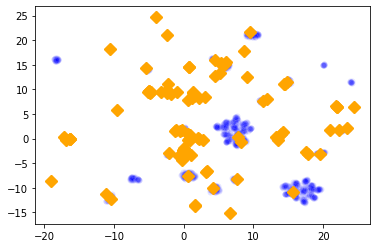

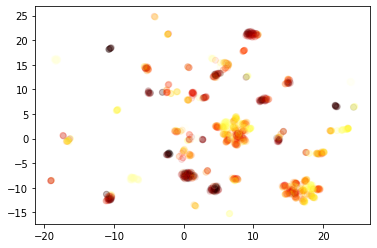

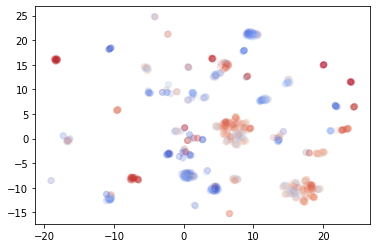

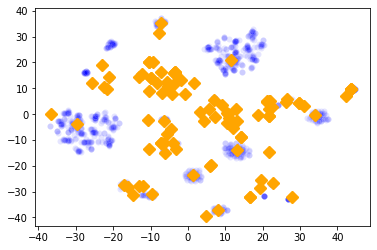

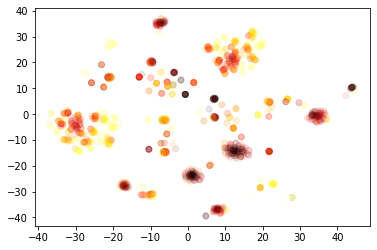

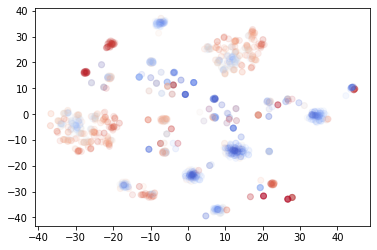

In [90]:
import seaborn as sns
for name, coords in zip(
            ['umap', 'tsne' ],
            [ X_umap, X_tsne ],
    ):
    # distinguish training from mutants
    plt.figure()
    sns.scatterplot(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                        color='blue', alpha=0.1,)
    plt.scatter(x=coords[labels == 0, 0], y=coords[labels == 0, 1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)
    # visualise mutant based on the acquisition (ranks)
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=acquisition_unk, alpha=0.1, cmap='hot')
    # visualize the mutant based on the rank data of the GP variances (uncertainty)
    plt.figure()
    plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                    c=ss.rankdata(y_var_mut), alpha=0.1, cmap='coolwarm')

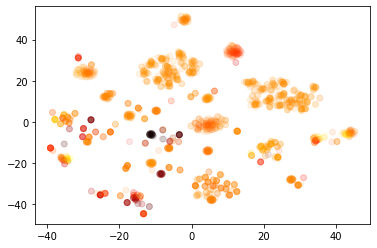

In [57]:
# label points in the TSNE so that Kd and rank info can be accessed
plt.figure()
plt.scatter(x=coords[labels == 1, 0], y=coords[labels == 1, 1],
                c=-acquisition_unk, alpha=0.1, cmap='hot')
plt.show()

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from MulticoreTSNE import MulticoreTSNE as TSNE
# Given observed data (obs_data) and unknown data (unknown_data)

# 1. Find nearest neighbors for each unknown point using observed data.
nbrs = NearestNeighbors(n_neighbors=1).fit(x_train_wt_array)
_, indices = nbrs.kneighbors(unknown_array)
tsne = TSNE(
        n_components=2,
        n_jobs=20,
    )

# 2. Apply t-SNE on the combined data
combined_data = np.vstack([x_train_wt_array, unknown_array])
tsne_results = tsne.fit_transform(combined_data)

# Split the t-SNE results back into observed and unknown parts
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

In [109]:
tsne_obs = X_tsne[:len(x_train_wt_array)]
tsne_unknown = X_tsne[len(x_train_wt_array):]

In [110]:
x_train_wt_array

array([[ 0.023891  , -0.03831439, -0.07290564, ..., -0.22226152,
         0.02643499,  0.11225177],
       [ 0.0240121 ,  0.00367938,  0.02346238, ..., -0.24938402,
         0.11721389,  0.16941018],
       [ 0.05326403,  0.04403213, -0.0232374 , ..., -0.1735692 ,
        -0.04422903,  0.23135675],
       ...,
       [-0.07817758, -0.02313735, -0.0655627 , ..., -0.22081426,
         0.0263268 ,  0.12111432],
       [-0.01302454, -0.07257082, -0.01249163, ..., -0.03220332,
        -0.03510378,  0.05690523],
       [ 0.0280782 ,  0.00933257,  0.04690858, ..., -0.24938402,
         0.11721389,  0.16941018]], dtype=float32)

/opt/rh/rh-python38/root/usr/local/lib64/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


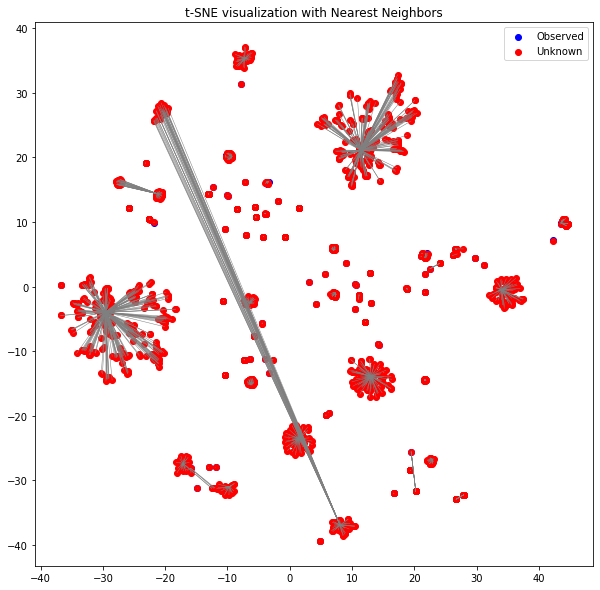

In [111]:

# 3. Plot
plt.figure(figsize=(10, 10))

# Plot observed points in blue
plt.scatter(tsne_obs[:, 0], tsne_obs[:, 1], color='blue', label='Observed')

# Plot unknown points in red
plt.scatter(tsne_unknown[:, 0], tsne_unknown[:, 1], color='red', label='Unknown')

# Draw lines between each unknown point and its nearest observed neighbor
for i, index in enumerate(indices):
    plt.plot([tsne_unknown[i, 0], tsne_obs[index, 0]],
             [tsne_unknown[i, 1], tsne_obs[index, 1]],
             color='grey', linestyle='-', linewidth=0.5)

plt.legend()
plt.title("t-SNE visualization with Nearest Neighbors")
plt.show()

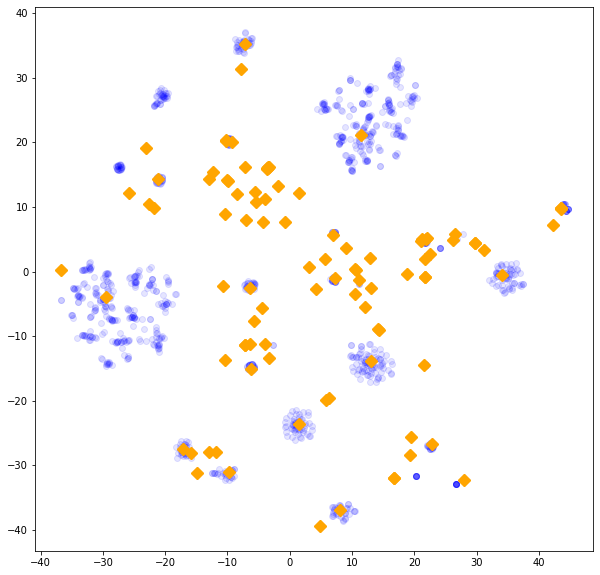

In [112]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_unknown[:,0], tsne_unknown[:,1], color='blue', alpha=0.1,)
plt.scatter(tsne_obs[:,0], tsne_obs[:,1],
                    color='orange', alpha=1.0, marker='x', linewidths=10,)